Table of Contents
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Analysis
## Data Exploration

In [32]:
# Math stuff
import numpy as np
# For handling dataset
import pandas as pd
# For plotting
import matplotlib.pyplot as plt
# For plotting
import seaborn as sns
sns.set_style("white")
# For list the feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer

Let's load the data in order to do some analysis

In [3]:
df = pd.read_csv('creditcard.csv')
df[:].head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

As we can see, the dataset contains 31 features which each one is a numerical data. <br />
The feature Class is a categorical data labeling if the transaction is legit or fraud. <br />
One of the characteristics is the highly imbalance between legit and fraud transaction.

So, let's plot and see it.

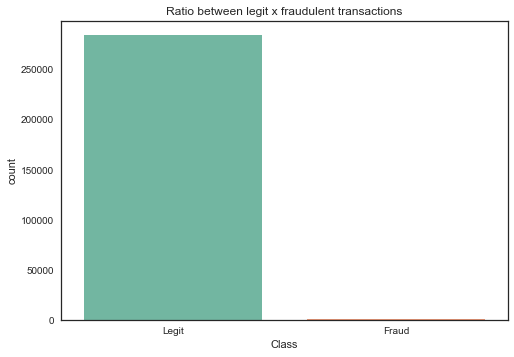

In [10]:
fig = plt.figure()

sns.countplot(df.Class, palette="Set2")
plt.xticks([0,1], ['Legit', 'Fraud'])
plt.title('Ratio between legit x fraudulent transactions')

fig.savefig('imgs/fig2 ratio-legitxfraud.png')

plt.show()

Now, let's summarize the whole data...

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.010663e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.694249e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.927028e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.137024e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


This summary is hard to see something. But, here some things to notice:
* The mean of the feature V1 to V28 are next to zero.
* The difference between the max value and the 75% quantile of the feature Amount is huge.


Let's plot the distributions of the features Vs.

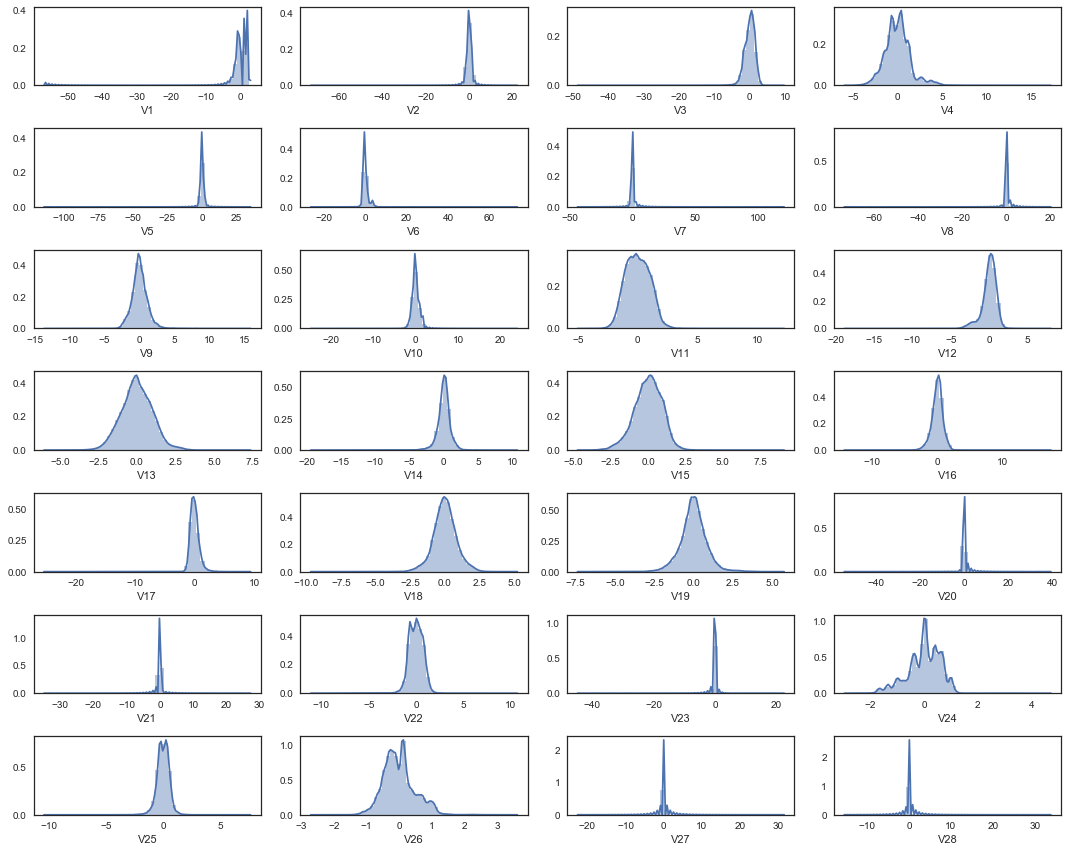

In [48]:
fig = plt.figure(figsize=(15, 12))

for idx, feat in enumerate(feats):
    plt.subplot(7, 4, idx+1) 
    sns.distplot(df[feat])

plt.tight_layout()
plt.show()

fig.savefig('imgs/Vs distplot.png')

The plot above is clear to see that the mean is around zero. So, it reflects the summary. <br />
Another thing to notice is that by the extension of the x-axis, show us that most of the feature Vs have outliers. <br />

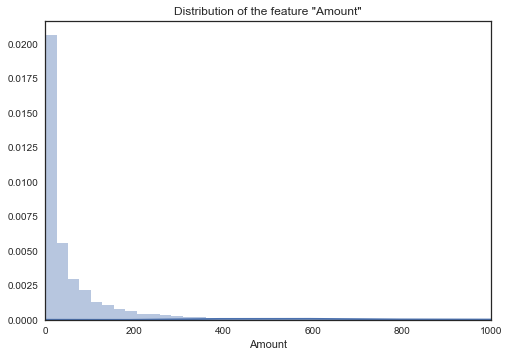

In [31]:
fig = plt.figure()

plt.title('Distribution of the feature "Amount"')
sns.distplot(df.Amount, bins=1000)
plt.xlim(0, 1000)
plt.show()

fig.savefig('imgs/fig3.png')

The feature amount is positively-skewed. So, it will need a transformation.

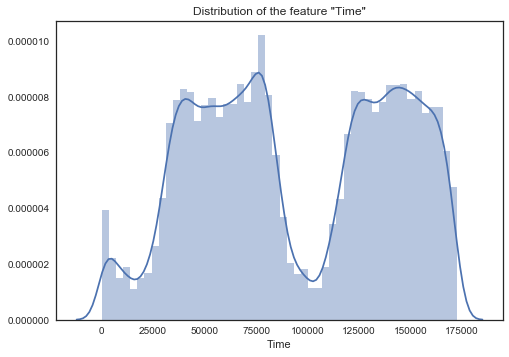

In [33]:
fig = plt.figure()

sns.distplot(df.Time)
plt.title('Distribution of the feature "Time"')
plt.show()

fig.savefig('imgs/fig4.png')

This feature presents somehow a bimodal distribution. Since, the dataset contains transactions of two days, this could be a reflection of it. <br /><br />
Now that we had an overview about the dataset, it might be a good idea to choose the features that most explain the relation between legit and fraud.

I'll be doing this through Random Forest and list the features by importance.

In [ ]:
# Since I won't be working with recurrent model, I'll be ignoring this feature
del df['Time']

In [45]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [48]:
X.Amount = FunctionTransformer(np.log).fit_transform(X.Amount.reshape(-1, 1))

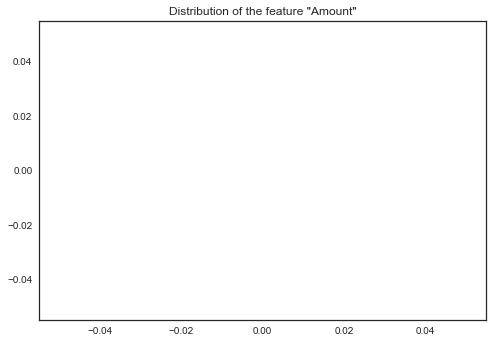

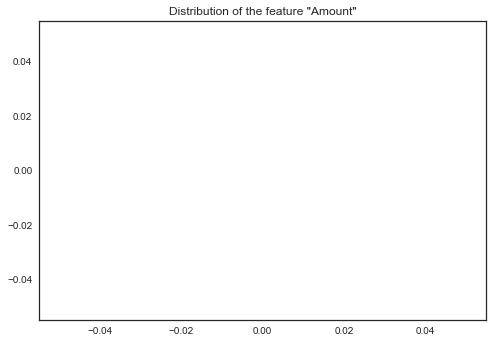

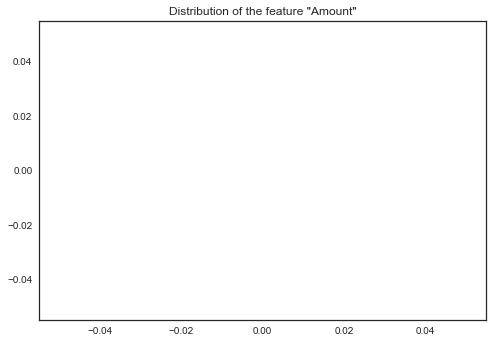

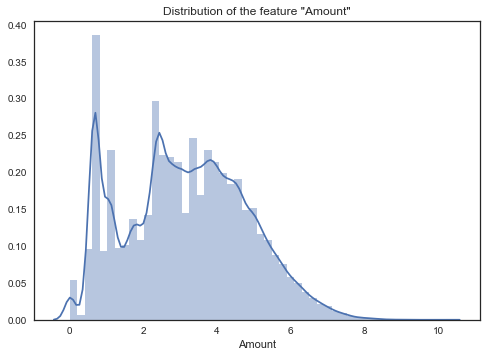

In [49]:
fig = plt.figure()

plt.title('Distribution of the feature "Amount"')
sns.distplot(X.Amount)

plt.show()


In [56]:
clf = RandomForestClassifier()
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [57]:
importance = {item[0]:float(item[1]) for item in zip(df.columns[1:-1], clf.feature_importances_)}
feat_imp = []
for w in sorted(importance.iteritems(), key=lambda (k,v):(v,k), reverse=True):
    feat_imp.append(np.array(w))
feat_imp = np.array(feat_imp)

In [58]:
feat_imp

array([['V18', '0.214471120082'],
       ['V13', '0.184364525114'],
       ['V15', '0.112040732086'],
       ['V12', '0.0578284504121'],
       ['V17', '0.052593003368'],
       ['V11', '0.0367247197042'],
       ['V3', '0.0299462446966'],
       ['V8', '0.0290303435563'],
       ['V5', '0.0285949652453'],
       ['V6', '0.0203317320329'],
       ['Amount', '0.0180191000989'],
       ['V21', '0.0159146517493'],
       ['V22', '0.0151252453939'],
       ['V27', '0.014420730984'],
       ['V10', '0.0141576149603'],
       ['V4', '0.0140586051795'],
       ['V9', '0.0133654306984'],
       ['V2', '0.01317074784'],
       ['V14', '0.0130422233035'],
       ['V19', '0.0121691905621'],
       ['V16', '0.0118063861818'],
       ['V23', '0.0112241993075'],
       ['V7', '0.0106186072063'],
       ['V24', '0.0104823891285'],
       ['V26', '0.0101148748985'],
       ['V25', '0.00916933999247'],
       ['V20', '0.00790768026064'],
       ['V28', '0.00645218048535']], 
      dtype='|S16')

In [25]:
feat_imp[:5]

array([['V13', '0.174781188102'],
       ['V15', '0.144827681638'],
       ['V11', '0.127066543245'],
       ['V18', '0.115516014742'],
       ['V17', '0.0692779231177']], 
      dtype='|S16')

http://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers
    
http://scikit-learn.org/stable/modules/feature_selection.html

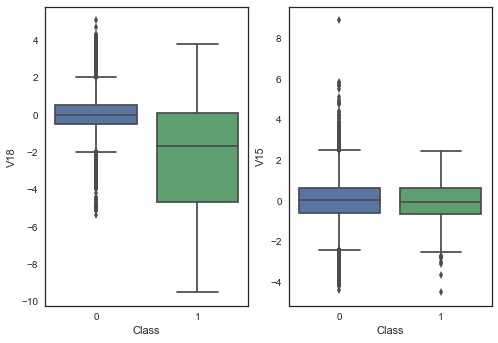

In [55]:
plt.subplot(121)
sns.boxplot(data=df, y='V18', x='Class')

plt.subplot(122)
sns.boxplot(data=df, y='V15', x='Class')

plt.show()